### Training a Sarcasm Detection Model using Bidirectional LSTMs

In [1]:
#importing Libraries

import json
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
file_path="D:\\Tensorflow_Works\\8-Sentiment_in_Text\\sarcasm.json"

with open(file_path, "r") as file:
    data = json.load(file)

data[0] 

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
 'is_sarcastic': 0}

In [3]:
sentences = []
labels = []
for element in data:
    sentences.append(element['headline'])
    labels.append(element['is_sarcastic'])

In [7]:
#setting parameters to easily tweak them when needed

#number of examples to use for training
training_size = 20000

#vocabulary size of tokenizer
vocab_size=10000

#maximum length of the padded sequences
max_length = 32

#output dimensions of the embedding layer
embedding_dims = 16

In [8]:
#splitting into train and test dataset
train_sentences = sentences[:training_size]
train_labels = labels[:training_size]

test_sentences = sentences[training_size:]
test_labels = labels[training_size:]

In [10]:
#defining vectorize layer

vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)

#generating vocabulary using training data

vectorize_layer.adapt(train_sentences)

In [13]:
def preprocessing(sequences):

    sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

    sequences = sequences.get_single_element()

    padded_sequence = tf.keras.utils.pad_sequences(sequences.numpy(), padding="pre", truncating="post", maxlen=max_length)

    padded_sequence = tf.data.Dataset.from_tensor_slices(padded_sequence)

    return padded_sequence


In [20]:
pad_train_sentences = preprocessing(tf.data.Dataset.from_tensor_slices(vectorize_layer(train_sentences)))
pad_test_sentences = preprocessing(tf.data.Dataset.from_tensor_slices(vectorize_layer(test_sentences)))


In [21]:
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels)

In [22]:
train_dataset = tf.data.Dataset.zip(pad_train_sentences, train_labels_dataset)
test_dataset = tf.data.Dataset.zip(pad_test_sentences, test_labels_dataset)

In [23]:
#optimizing dataset for training
shuffle_buffer_size=1000
prefetch_buffer_size=tf.data.AUTOTUNE
batch_size=32

train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(shuffle_buffer_size)
                       .batch(batch_size)
                       .prefetch(prefetch_buffer_size))

test_dataset_final = (test_dataset
                       .cache()
                       .batch(batch_size)
                       .prefetch(prefetch_buffer_size))



In [24]:
#model building

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(max_length,)),
    tf.keras.layers.Embedding(vocab_size, embedding_dims),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,601 (678.13 KB)

 Trainable params: 173,601 (678.13 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(loss="binary_crossentropy",
             metrics=['accuracy'],
              optimizer="adam")

In [26]:
history = model.fit(train_dataset_final, epochs=10, validation_data=test_dataset_final)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7966 - loss: 0.4152 - val_accuracy: 0.8527 - val_loss: 0.3389
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9104 - loss: 0.2223 - val_accuracy: 0.8563 - val_loss: 0.3698
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9493 - loss: 0.1373 - val_accuracy: 0.8508 - val_loss: 0.4614
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9722 - loss: 0.0820 - val_accuracy: 0.8487 - val_loss: 0.5949
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9850 - loss: 0.0474 - val_accuracy: 0.8410 - val_loss: 0.7829
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9901 - loss: 0.0311 - val_accuracy: 0.8348 - val_loss: 0.8943
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9926 - loss: 0.0246 - val_accuracy: 0.8356 - val_loss: 0.9262
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9962 - loss: 0.0146 - val_accuracy: 0.

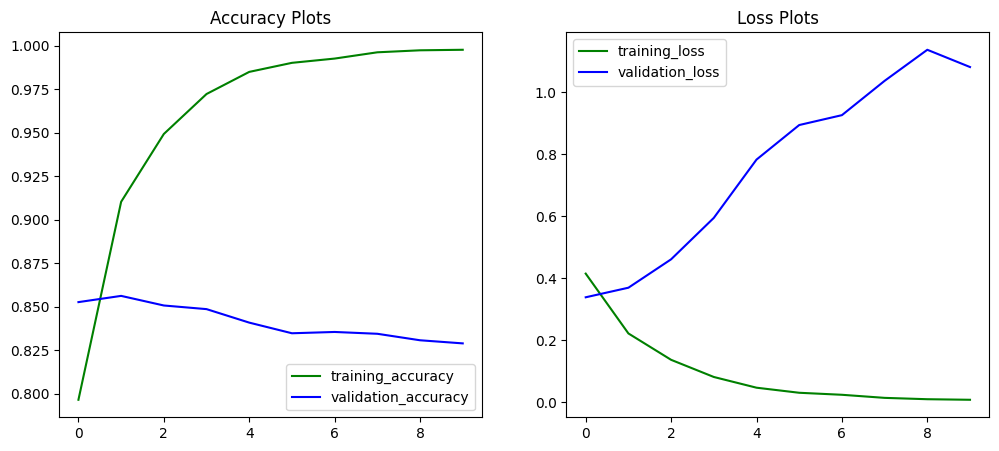

In [27]:
def visualize(history):

    plt.subplots(1,2,figsize=(12,5))
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    plt.subplot(1,2,1)
    plt.plot(epochs, accuracy, "g", label="training_accuracy")
    plt.plot(epochs, val_accuracy, 'b', label="validation_accuracy")
    plt.title("Accuracy Plots")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, "g", label="training_loss")
    plt.plot(epochs, val_loss, 'b', label="validation_loss")
    plt.title("Loss Plots")
    plt.legend()


visualize(history)